<a href="https://colab.research.google.com/github/Anik-1802021/ML_Autoencoder_Increase_Performance/blob/main/Increase%20PNSSR%20v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D,MaxPool2D ,UpSampling2D, Flatten, Input
from keras.optimizers import SGD, Adam, Adadelta, Adagrad
from keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from math import log10,sqrt

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
train_images=sorted(os.listdir('/content/drive/MyDrive/NORMAL'))

In [9]:
train_image=[]
for im in train_images:
  img=image.load_img('/content/drive/MyDrive/NORMAL/'+im,target_size=(512,512),color_mode='grayscale')
  img=image.img_to_array(img)
  img=img/255
  train_image.append(img)

train_df=np.array(train_image)

In [10]:
#Subplotting images
def plot_img(dataset):
  f,ax=plt.subplots(1,5)
  f.set_size_inches(40,20)
  for i in range(5,10):
    ax[i-5].imshow(dataset[i].reshape(512,512), cmap='gray')
  plt.show()

In [11]:
#Adding gaussian noise with 0.05 factor
def add_noise(image):
  row,col,ch=image.shape
  mean=0
  sigma=1
  gauss=np.random.normal(mean,sigma,(row,col,ch))
  gauss=gauss.reshape(row,col,ch)
  noisy=image+gauss*0.05
  return noisy

In [12]:
noised_df=[]
for img in train_df:
  noisy=add_noise(img)
  noised_df.append(noisy)

noised_df=np.array(noised_df)

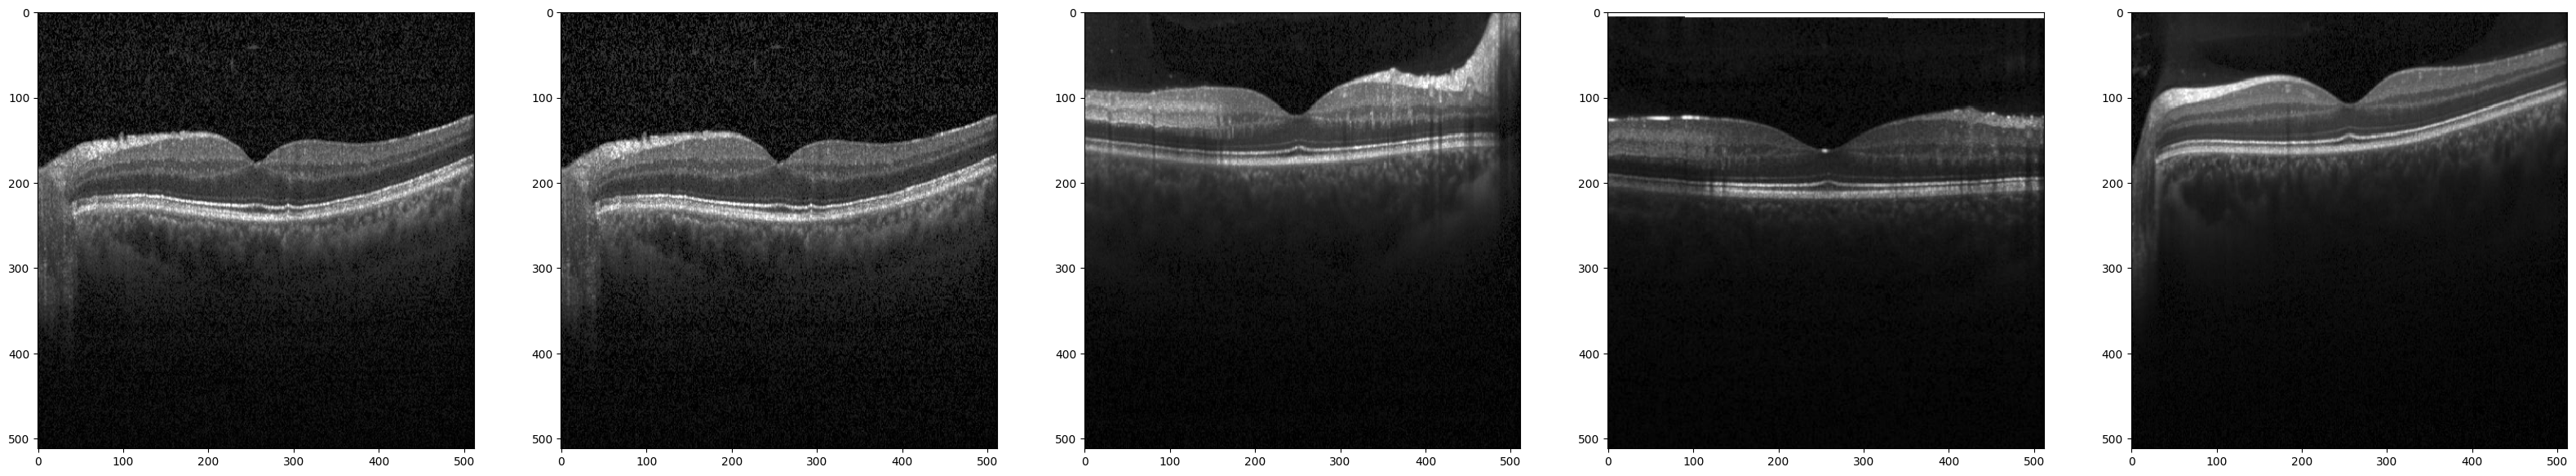

In [13]:
plot_img(train_df)

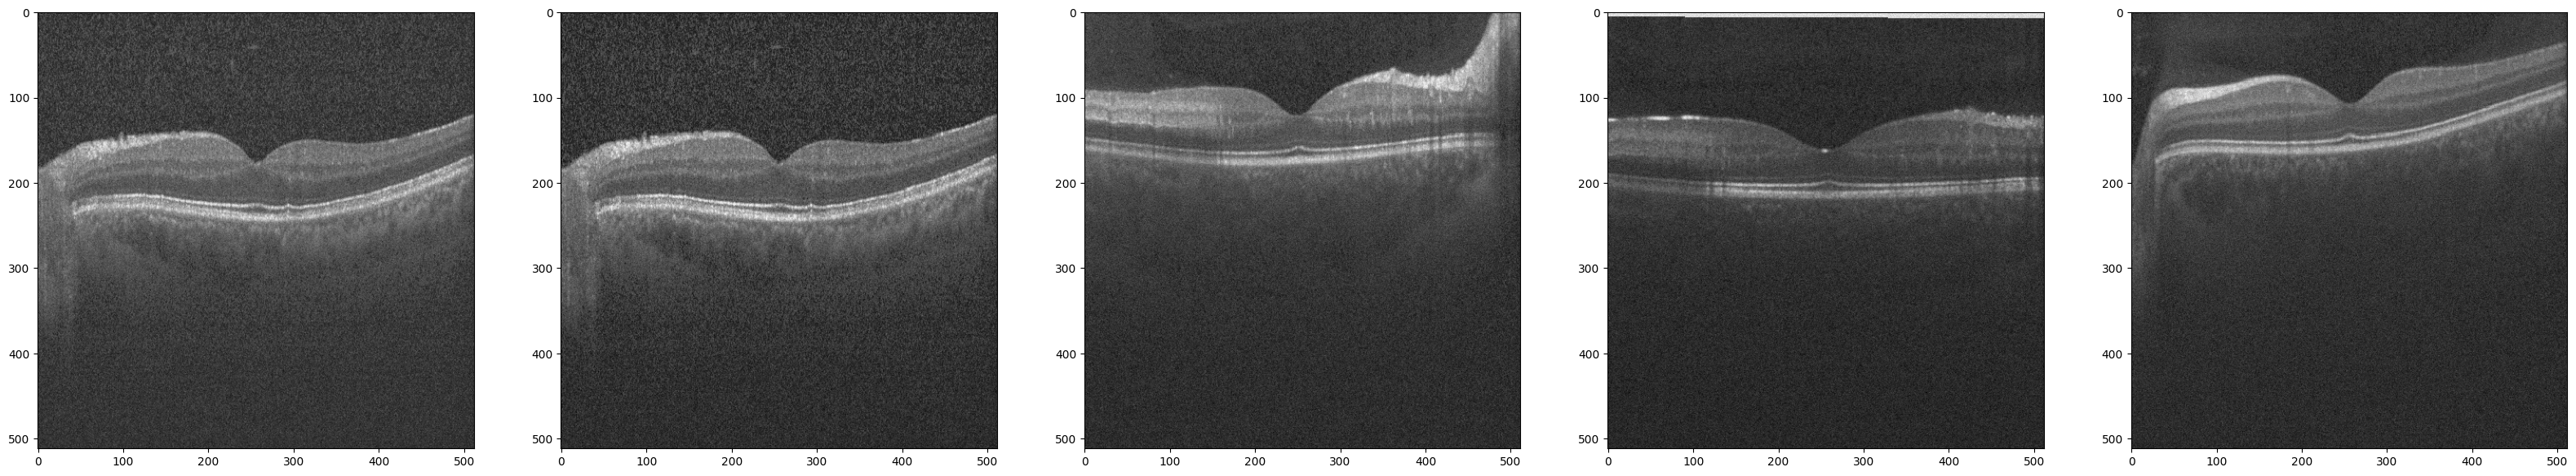

In [14]:
plot_img(noised_df)

In [23]:
original_train=train_df[:400]
original_test=train_df[400:]

In [24]:
def autoencoder():
  input_img=Input(shape=(512,512,1),name='image_input')
  #enoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
  x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv2')(x)
  x = MaxPooling2D((2,2), padding='same', name='pool2')(x)

  #decoder
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv3')(x)
  x = UpSampling2D((2,2), name='upsample1')(x)
  x = Conv2D(64, (3,3), activation='relu', padding='same', name='Conv4')(x)
  x = UpSampling2D((2,2), name='upsample2')(x)
  x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv5')(x)

  #model
  autoencoder = Model(inputs=input_img, outputs=x)
  autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

  return autoencoder

In [25]:
model= autoencoder()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 512, 512, 1)]     0         
                                                                 
 Conv1 (Conv2D)              (None, 512, 512, 64)      640       
                                                                 
 pool1 (MaxPooling2D)        (None, 256, 256, 64)      0         
                                                                 
 Conv2 (Conv2D)              (None, 256, 256, 64)      36928     
                                                                 
 pool2 (MaxPooling2D)        (None, 128, 128, 64)      0         
                                                                 
 Conv3 (Conv2D)              (None, 128, 128, 64)      36928     
                                                                 
 upsample1 (UpSampling2D)    (None, 256, 256, 64)      0   

In [26]:
with tf.device('/device:GPU:0'):
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
    model.fit(noised_train, original_train, epochs=18, batch_size=10, validation_data=(noised_test, original_test), callbacks=[early_stopping])

Epoch 1/18
40/40 [==============================] - 23s 277ms/step - loss: 0.4461 - val_loss: 0.3513
Epoch 2/18
40/40 [==============================] - 9s 226ms/step - loss: 0.3555 - val_loss: 0.3444
Epoch 3/18
40/40 [==============================] - 9s 229ms/step - loss: 0.3501 - val_loss: 0.3423
Epoch 4/18
40/40 [==============================] - 9s 236ms/step - loss: 0.3479 - val_loss: 0.3406
Epoch 5/18
40/40 [==============================] - 9s 229ms/step - loss: 0.3469 - val_loss: 0.3482
Epoch 6/18
40/40 [==============================] - 9s 228ms/step - loss: 0.3473 - val_loss: 0.3394
Epoch 7/18
40/40 [==============================] - 9s 232ms/step - loss: 0.3457 - val_loss: 0.3388
Epoch 8/18
40/40 [==============================] - 9s 224ms/step - loss: 0.3452 - val_loss: 0.3384
Epoch 9/18
40/40 [==============================] - 9s 229ms/step - loss: 0.3449 - val_loss: 0.3380
Epoch 10/18
40/40 [==============================] - 9s 229ms/step - loss: 0.3447 - val_loss: 0.338

In [66]:
noised_test =noised_df[400:]

1/1 [==============================] - 0s 27ms/step


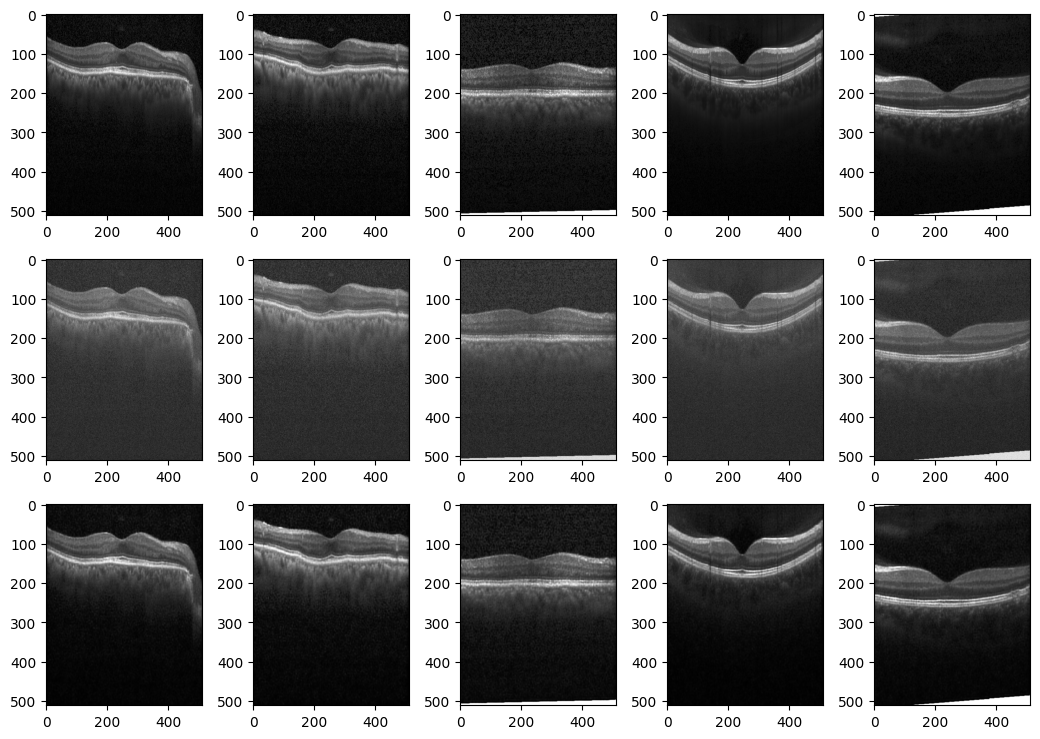

In [70]:
pred= model.predict(noised_test[:5])
def plot_predictions(y_true, y_pred):
    f, ax = plt.subplots(3, 5)
    f.set_size_inches(10.5,7.5)
    for i in range(5):
        ax[0][i].imshow(np.reshape(original_test[i], (512, 512)), aspect='auto', cmap='gray')
        ax[1][i].imshow(np.reshape(y_true[i], (512, 512)), aspect='auto', cmap='gray')
        ax[2][i].imshow(np.reshape(y_pred[i], (512, 512)), aspect='auto', cmap='gray')
    plt.tight_layout()
plot_predictions(noised_test[:5], pred[:5])

In [75]:
noised_test = noised_test.astype(np.float32)
print(original_test[0].dtype)

float32


Text(0.5, 1.0, 'Bilateral Filter')

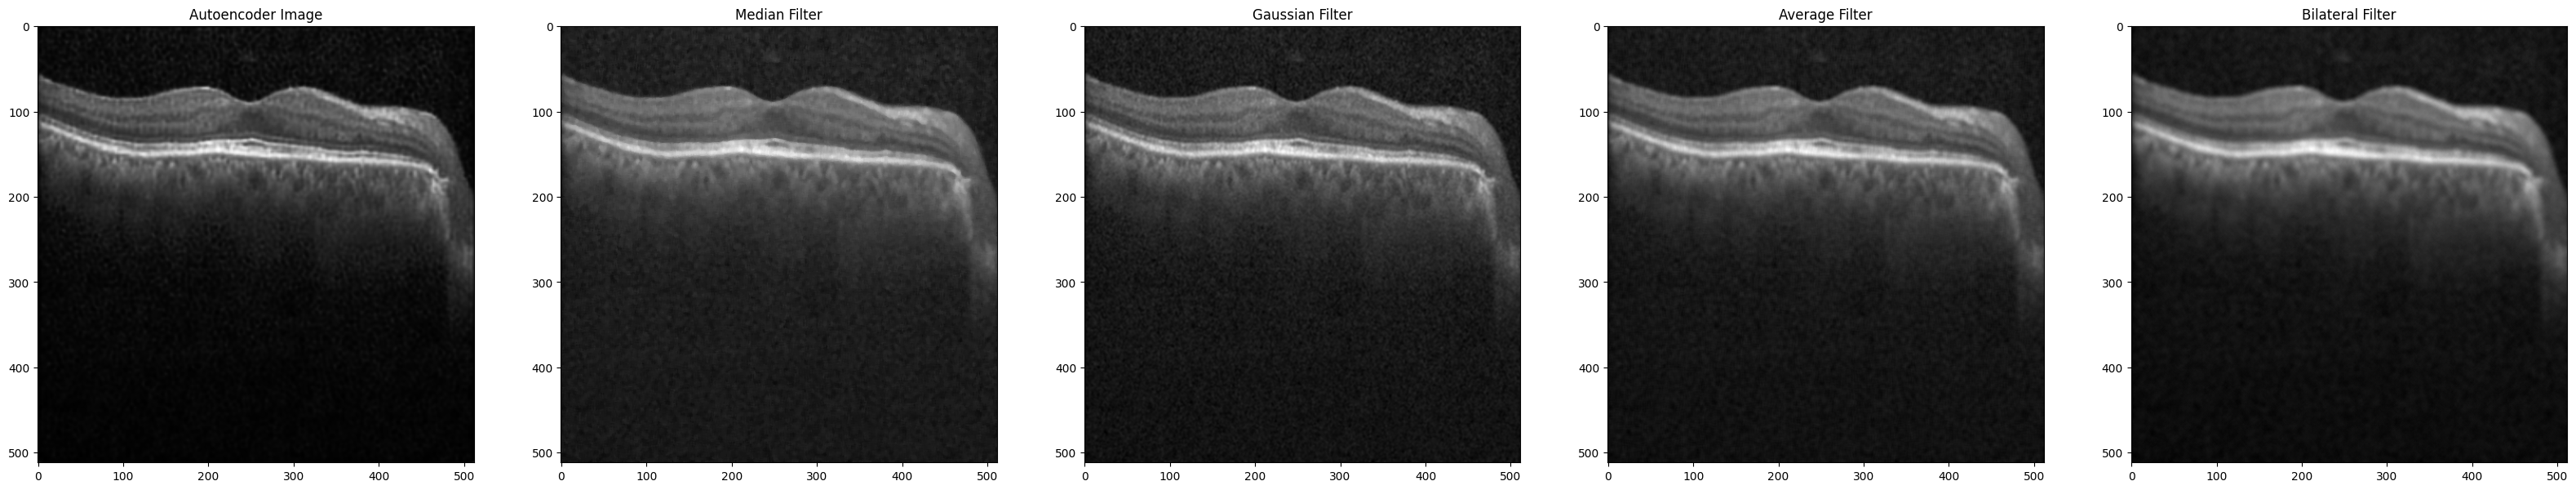

In [76]:
median_blur = cv2.medianBlur(noised_test[0], (5))
gaussian_blur=cv2.GaussianBlur(noised_test[0],(5,5),0)
average_blur=cv2.blur(noised_test[0],(5,5))
bilateral_filter=cv2.bilateralFilter(noised_test[0],9,75,75)
f,ax=plt.subplots(1,5)
f.set_size_inches(40,20)
ax[0].imshow(pred[0].reshape(512, 512), cmap='gray')
ax[0].set_title('Autoencoder Image')
ax[1].imshow(median_blur,cmap='gray')
ax[1].set_title('Median Filter')
ax[2].imshow(gaussian_blur,cmap='gray')
ax[2].set_title('Gaussian Filter')
ax[3].imshow(average_blur,cmap='gray')
ax[3].set_title('Average Filter')
ax[4].imshow(bilateral_filter,cmap='gray')
ax[4].set_title('Bilateral Filter')

In [85]:
def PSNR(original, denoised):
    mse = np.mean((original - denoised) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel/sqrt(mse))
    return psnr

value1 = PSNR(original_test[0], median_blur)
value2 = PSNR(original_test[0], pred[0])
value3 = PSNR(original_test[0], gaussian_blur)
value4 = PSNR(original_test[0], average_blur)
value5 = PSNR(original_test[0], bilateral_filter)

print("PSNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")

PSNR values
Autoencoder Image : 78.28605829714405 dB
Median Filter Image : 61.81389691345146 dB
Gaussian Filter Image : 61.78592661129529 dB
Average Filter Image : 61.825395514397144 dB
Bilateral Filter Image : 61.86647971465432 dB


In [84]:
def MSE (original, denoised):
    mse = np.mean((original - denoised) ** 2)
    return mse

value1 = MSE(original_test[0], median_blur)
value2 = MSE(original_test[0], pred[0])
value3 = MSE(original_test[0], gaussian_blur)
value4 = MSE(original_test[0], average_blur)
value5 = MSE(original_test[0], bilateral_filter)

print("MSE values")
print(f"Autoencoder Image : {value2} ")
print(f"Median Filter Image : {value1} ")
print(f"Gaussian Filter Image : {value3} ")
print(f"Average Filter Image : {value4} ")
print(f"Bilateral Filter Image : {value5} ")

MSE values
Autoencoder Image : 0.0009648827253840864 
Median Filter Image : 0.042824339121580124 
Gaussian Filter Image : 0.04310103505849838 
Average Filter Image : 0.042711105197668076 
Bilateral Filter Image : 0.04230896383523941 


In [86]:
def SNR(original, denoised):
    signal = original
    noise = original - denoised

    # Calculate the sum of squares
    signal_power = np.sum(signal ** 2)
    noise_power = np.sum(noise ** 2)

    # Calculate SNR in dB
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

value1 = SNR(original_test[0], median_blur)
value2 = SNR(original_test[0], pred[0])
value3 = SNR(original_test[0], gaussian_blur)
value4 = SNR(original_test[0], average_blur)
value5 = SNR(original_test[0], bilateral_filter)

print("SNR values")
print(f"Autoencoder Image : {value2} dB")
print(f"Median Filter Image : {value1} dB")
print(f"Gaussian Filter Image : {value3} dB")
print(f"Average Filter Image : {value4} dB")
print(f"Bilateral Filter Image : {value5} dB")



SNR values
Autoencoder Image : 15.870898962020874 dB
Median Filter Image : -27.693960666656494 dB
Gaussian Filter Image : -27.72193193435669 dB
Average Filter Image : -27.682464122772217 dB
Bilateral Filter Image : -27.641377449035645 dB
